In [2]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
from functools import partial
from scipy.optimize import minimize

import torch
import torch.optim as optim
from torch.optim import Adam

from nflows.flows import MaskedAutoregressiveFlow
from matplotlib import cm, ticker
from numpy import ma

In [3]:
from counterfactuals.utils import plot_distributions

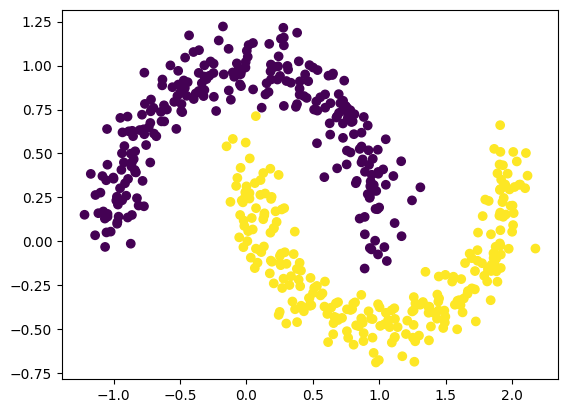

In [4]:
x, y = datasets.make_moons(512, noise=0.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

# Train generative model

In [5]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
optimizer = optim.Adam(flow.parameters())

num_iter = 10000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    if (i + 1) % 1000 == 0:
        print(loss.item())

0.5365766882896423
0.37180227041244507
0.3675934076309204
0.2939850986003876
0.4272456765174866
0.3323826491832733
0.3626786768436432
0.1856936514377594
0.3278031349182129
0.33342018723487854


# Generative model only approach
$$ p(\mathbf{x}|y)=\gamma $$
$$ \min_{\mathbf{x}'} d(\mathbf{x}, \mathbf{x}') + \lambda \cdot \max (\max(p(\mathbf{x}'|y)+\beta, \gamma) - p(\mathbf{x}'|y'), 0) $$

In [6]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=20.0, beta=0.01):
    model.eval()
    dist = torch.linalg.norm(x_origin-x, axis=1)

    y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)

    p_x_param_c_orig = model.log_prob(x, context=y_orig).exp()
    p_x_param_c_target = model.log_prob(x, context=y_hat).exp()
    p_x_orig_c_orig = model.log_prob(x_origin, context=torch.zeros(x_origin.shape[0]).reshape(-1, 1)).exp()

    p_x_param_c_orig_with_beta = p_x_param_c_orig + beta
    max_inner = torch.clamp(p_x_param_c_orig_with_beta, min=p_x_orig_c_orig)
    max_outer = torch.clamp(max_inner - p_x_param_c_target, min=torch.Tensor([0.0]))
    loss = dist + alpha * max_outer
    return loss

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


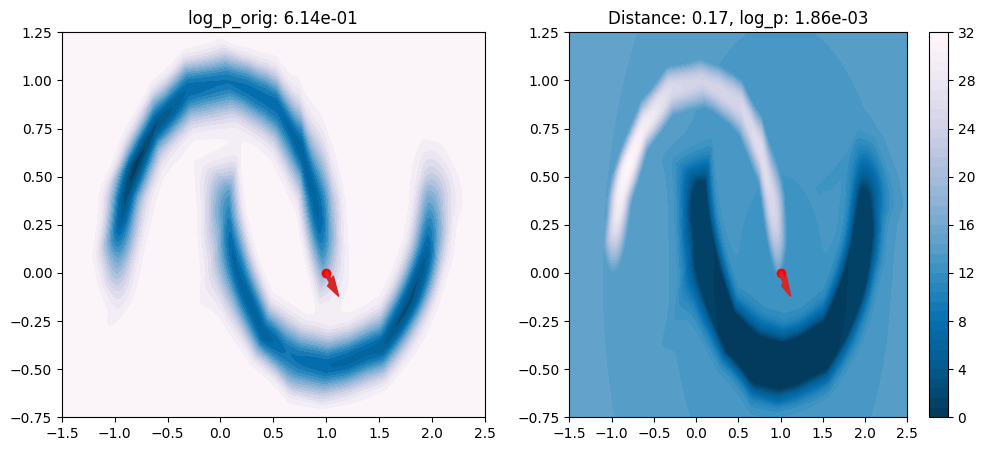

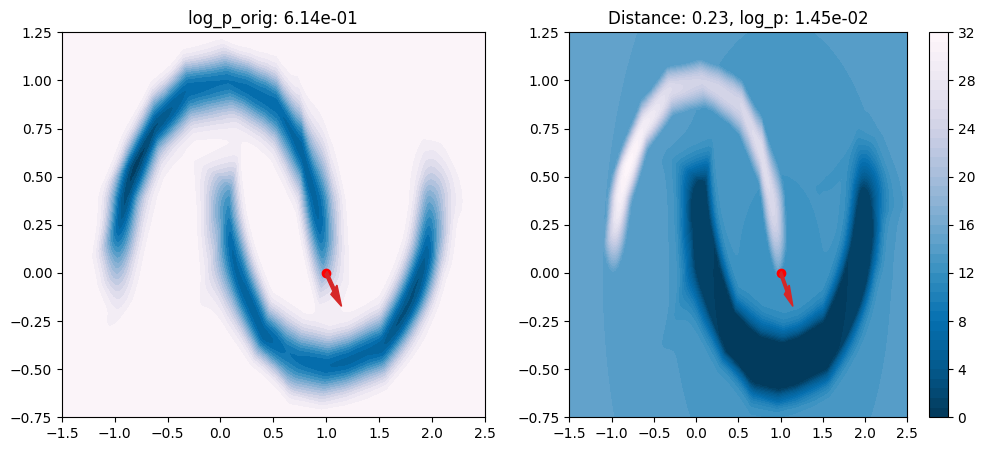

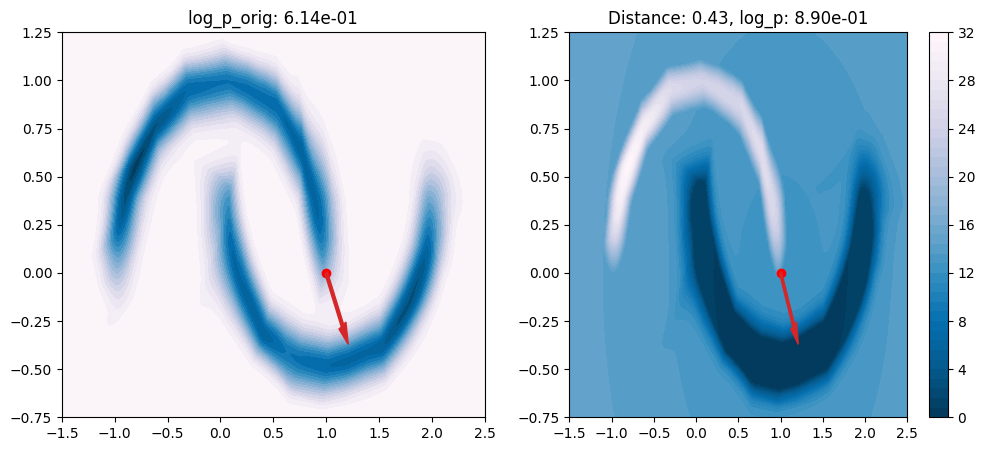

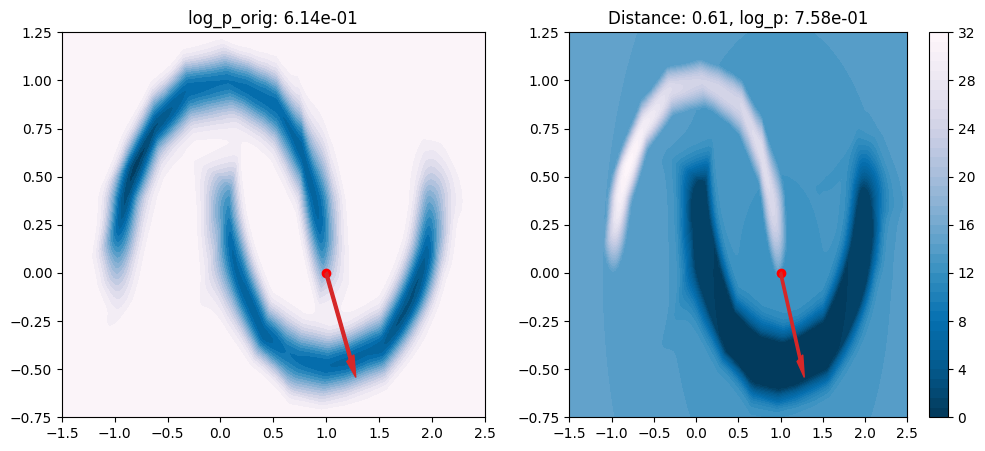

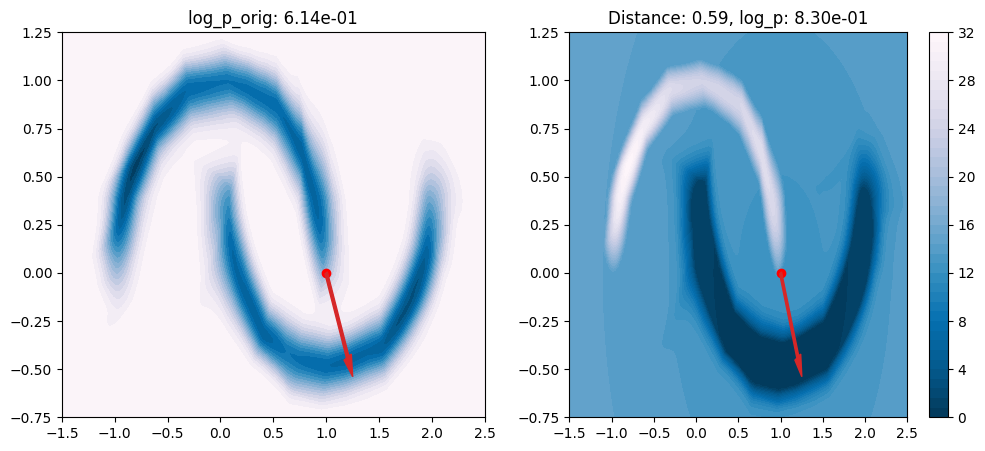

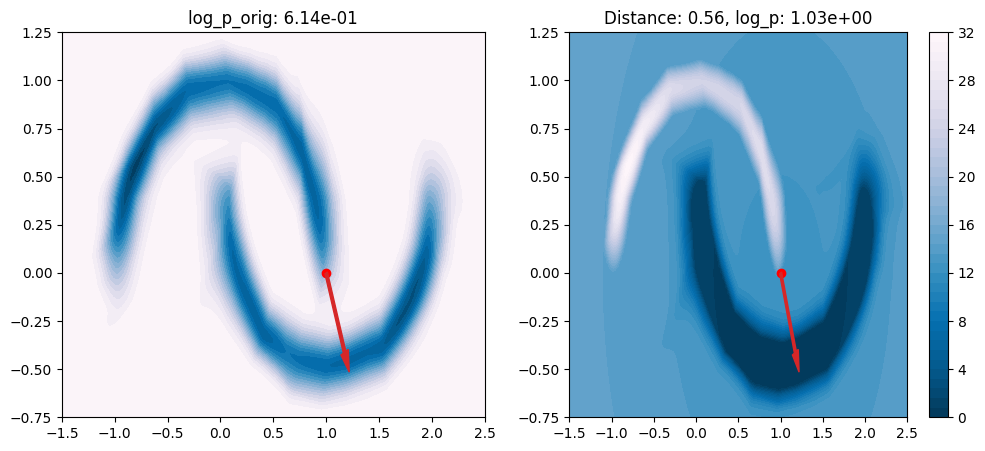

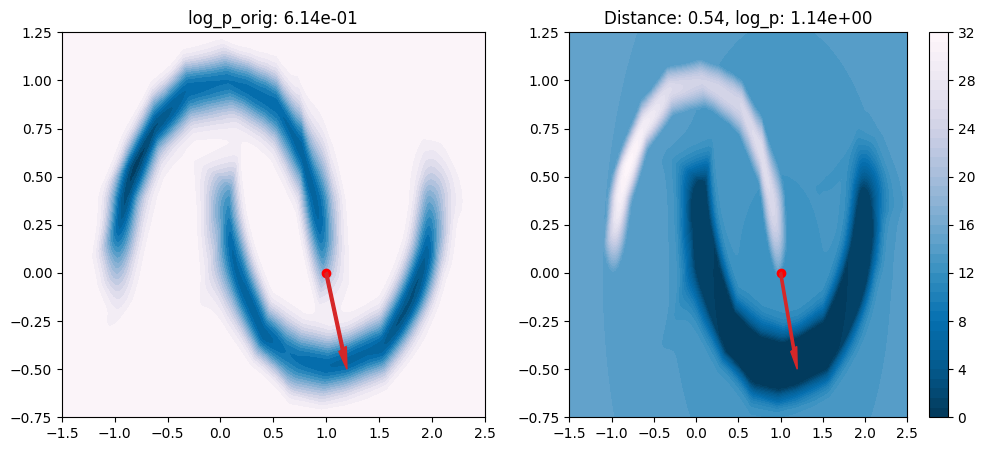

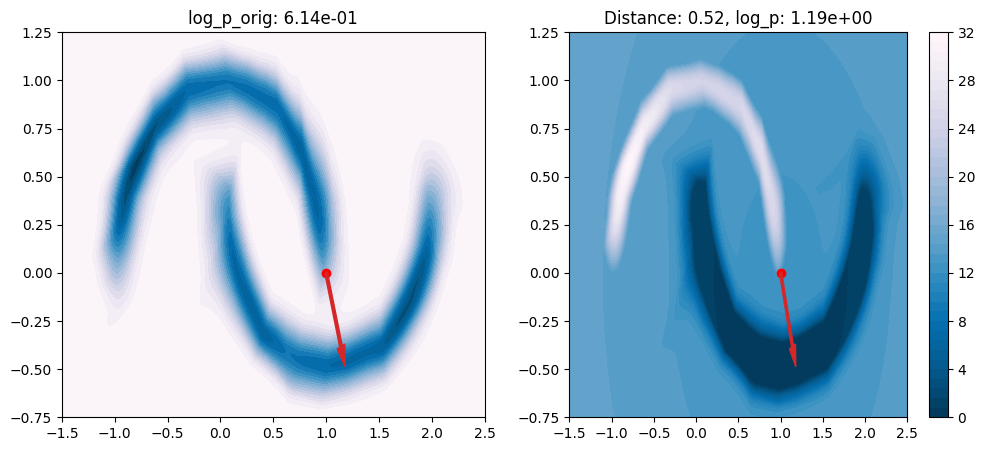

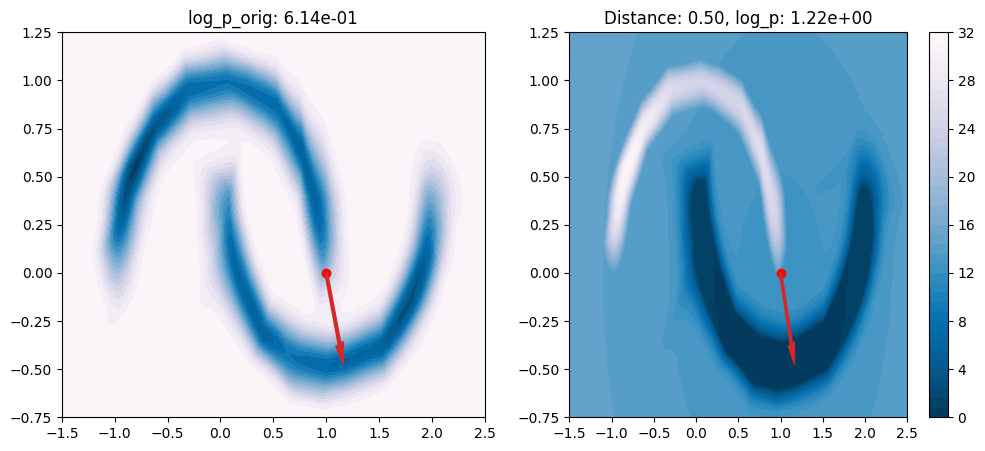

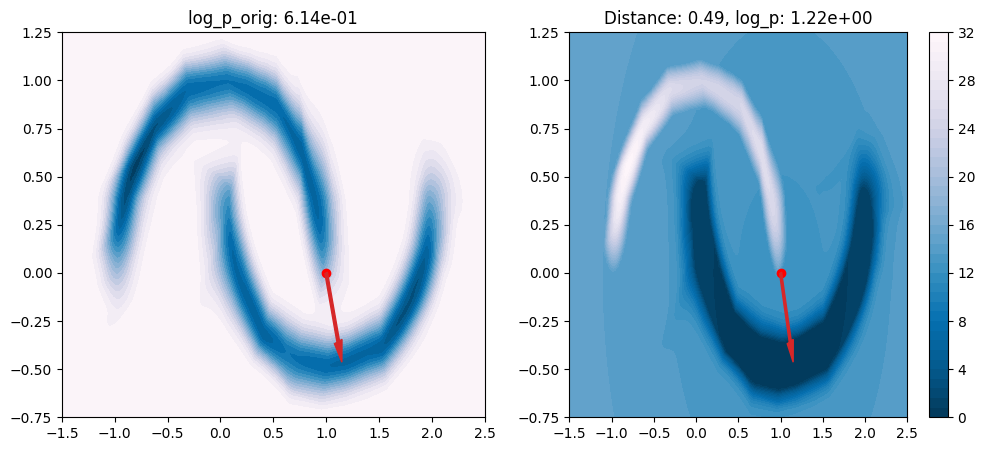

In [7]:
optimizer = Adam([x], lr=0.03)
alpha = 20

num_iterations = 100
for i in range(num_iterations):
    y = optim_function(x, x_origin, flow, alpha=alpha)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        plot_distributions(x, x_origin, flow, optim_function, alpha=alpha)